## Library imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch as t
from chromatography import *
%matplotlib inline

## Dataset Import

In [3]:
alist = pd.read_csv('../data/Peter32.csv')

## Useful functions definition

In [ ]:
run = ExperimentAnalytes(k0 = alist.k0.values[0:2], S = alist.S.values[0:2], h=0.001, grad='iso', run_time=None)

In [ ]:
run.run_all([0.37, 0.31, 0.47], [.25, .25, .25])
run.print_analytes(angle=50, rc=(13, 10))

In [4]:
import torch 
import torch.nn as nn
from torch import optim, tensor
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt

In [364]:
class Policy(nn.Module):
    def __init__(self, n_param):
        super(Policy, self).__init__()
        self.n_param = n_param
        
        # Define network
        self.fc_mu = nn.Linear(1, n_param, bias=False)
        self.sig = nn.Sigmoid()
        self.fc_sigma = nn.Linear(1, n_param, bias=False)
        self.softplus = nn.Softplus()
        
        
    def forward(self):
        out = torch.ones((1,1))
        self.mu = self.sig(self.fc_mu(out)).squeeze()
        self.sigma = self.softplus(self.fc_sigma(out)).squeeze()
        
        return self.mu, self.sigma
    
    def sample(self, n_samples):
        
        if self.n_param == 1:
            return (
                Normal(
                    self.mu, self.sigma
                )
                .sample((n_samples,))
            )
        else:
            return (
                MultivariateNormal(
                    self.mu, torch.diag(self.sigma)
                )
                .sample((n_samples,))
            )
        #return (self.mu + actions * self.sigma).clone().detach()

In [329]:
def reinforce_sample(exp, policy, delta_taus, positions, num_episodes=1000, batch_size=1, lr=0.001):

    losses = []
    mus = []
    js = []
    
    # Optimizer
    optimizer = optim.SGD(policy.parameters(), lr=lr)
    for n in range(num_episodes):
        # compute distribution parameters (Normal)
        policy.forward()
        mus.append(policy.mu.data)
        # Sample some values from the actions distributions
        
        programs = policy.sample(1)
        constr_programs = programs.clone()
        constr_programs[constr_programs > 1] = 1
        constr_programs[constr_programs < 0] = 0
        exp.reset()            
        exp.step(constr_programs[0].data.numpy(), delta_taus)
        loss = placement_error(exp.positions[-1], positions)
        J = placement_error(exp.positions[-1], positions) * log_prob(programs[0], policy.mu, policy.sigma)      
        losses.append(loss)
        optimizer.zero_grad()
        # Calculate gradients
        J.backward()
        # Apply gradients
        optimizer.step()
    return losses, mus

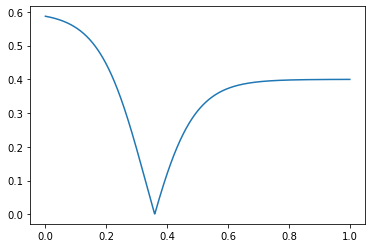

0.35935935935935936


In [559]:
exp_1 = ExperimentAnalytes(k0 = alist.k0.values[0:1], S = alist.S.values[0:1], h=0.001, grad='iso', run_time=0.5)
phis = np.linspace(0, 1, 1000)
Losses = []
for phi in phis:
    exp_1.reset()
    exp_1.step(phi, 0.5)
    Losses.append(placement_error(exp_1.positions[-1], [0.3]))

plt.plot(phis, Losses)
plt.show()
print(phis[np.argmin(Losses)])

In [560]:
exp = ExperimentAnalytes(k0 = alist.k0.values[0:1], S = alist.S.values[0:1], h=0.001, grad='iso', run_time=0.5)
pol = Policy(1)
losses = []
mus = []
sigmas = []

In [564]:
for i in range(20000):
    lr = 0.01
    if i > 10000 & i < 13500:
        lr = 0.001
    elif i >= 13500:
        lr = 0.0001
    pol.forward()
    mus.append(pol.mu.data)
    sigmas.append(pol.sigma.data)
    # Sample some values from the actions distributions
    optimizer = optim.SGD(pol.parameters(), lr=lr)
    programs = pol.sample(1)
    constr_programs = programs.clone()
    constr_programs[constr_programs > 1] = 1
    constr_programs[constr_programs < 0] = 0
    exp.reset()            
    exp.step(constr_programs[0].data.numpy(), 0.5)
    loss = placement_error(exp.positions[-1], [0.3])
    log = log_prob(programs[0], pol.mu, pol.sigma)       
    J = (loss ) * log
    losses.append(loss)
    optimizer.zero_grad()
    # Calculate gradients
    J.backward()
    # Apply gradients
    optimizer.step()

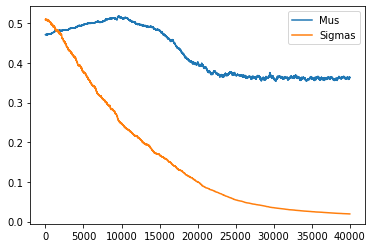

In [565]:
plt.plot(mus, label='Mus')
plt.plot(sigmas, label='Sigmas')
plt.legend()

In [566]:
print(sigmas[-1], mus[-1])

tensor(0.0192) tensor(0.3636)
